<a href="https://colab.research.google.com/github/aaoiii/2024-ESAA-OB/blob/main/12%EC%A3%BC%EC%B0%A8_%ED%85%90%EC%84%9C%ED%94%8C%EB%A1%9C_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PART 04 합성곱 신경망 (CNN)
## 01 합성곱 신경망
CNN : 데이터가 가진 특징들의 패턴을 학습하는 알고리즘
- ex) 이미지 분류, 객체 탐지, 스타일 전이
- **객체 탐지** : 이미지에서 특정 객체를 인식하고 이미지의 어디에 있는지 위치까지 파악
- 위치는 이미지의 좌표값으로 나타내기 때문에 회귀분석으로 경계박스를 찾는다
- **스타일전이** : 콘텐츠 이미지와 스타일 참조 이미지를 이용하여 콘텐츠의 기본 형태 유지하고 스타일을 입혀 새로운 이미지 생성

### 1-1 이미지 표현
- 0~255의 숫자로 픽셀의 화소 값 나타냄
  - 숫자 0 : 완전히 검은색
  - 숫자 255 : 흰색
- 화소를 나타내는 숫자는 이미지의 강도 나타냄
- 컬러 이미지는 R, G, B 채널로 구성된 3장의 이미지 겹쳐서 표현

### 1-2 합성곱
- 정방형 크기를 가지는 커널(필터) 사용하여 이미지에 대한 특성 추출
- **특성맵**
- 이미지의 일부분에 커널이 겹치도록 투영하고 겹치는 부분에 대하여 합성곱 연산 수행
- 원소별 곱셈 수행후 모두 더한 값으로 단일 스칼라 값을 특성맵에 입력
- n*n 개의 가중치를 가지고, 오차 역전파 시 커널의 가중치 업데이트
- 커널의 공유 가중치로 이미지 특성 추출에 효율적이다

### 1-3 채널
- 입력 이미지를 구헝하는 2차원 배열의 개수
- 컬러이미지처럼 입력 이미지가 여러개의 채널을 가지는 경우, 합성곱 연산을 수행할 때
  - 입력 이미지 채널 개수만큼 커널 생성
  - 각 채널마다 하나씩 커널 적용하여 합성곱 연산 수행
  - 원소별 덧셈 연산으로 모두 더해주어 특성맵 생성


### 1-4 스트라이드
- 스트라이드 : 커널을 이동하는 간격
- 2로 설정하면 특성맵의 크기가 반으로 줄어든다

### 1-5 패딩
- 추출된 특성맵의 크기가 입력 이미지 대비 줄어들지 않도록 패딩 설정
- zero-padding : 가장자리에 0으로 채워진 패딩 값으로 차운다
- padding='same'


### 1-6 특성맵 사이즈
((입력크기+2*패딩-필터크기)/스트라이드 + 1, (입력크기+2*패딩-필터크기)/스트라이드 + 1)


### 1-7 풀링
- 추출된 특성 맵에 대해 다운 샘플링하여 이미지의 크기를 축소하는 레이어
- 이미지 축소를 통해 연산량 감소하고 과대적합 방지
- 최대 값의 픽셀 선택


## 02 간단한 모델 생성

In [1]:
import tensorflow as tf

In [2]:
# mnist 손글씨 이미지 데이터 로드
mnist=tf.keras.datasets.mnist
(x_train,y_train),(x_valid,y_valid)=mnist.load_data()

print(x_train.shape,y_train.shape)
print(x_valid.shape,y_valid.shape)

11490434/11490434 [==============================] - 0s 0us/step
(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


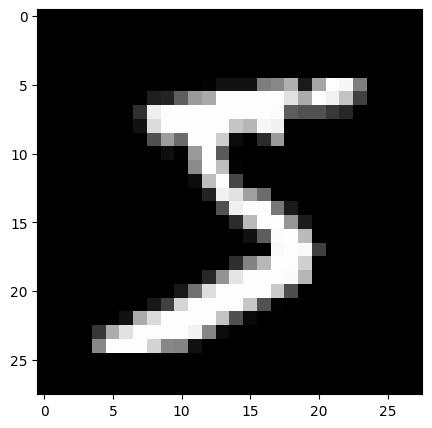

In [5]:
# 샘플 이미지 출력
import matplotlib.pyplot as plt

def plot_image(data,idx):
  plt.figure(figsize=(5,5))
  plt.imshow(data[idx],cmap='gray')
  plt.show()

plot_image(x_train,0)

In [6]:
print(x_train.min(),x_train.max())
print(x_valid.min(),x_valid.max())

0 255
0 255


In [7]:
# 정규화 (Normalization)
x_train = x_train / 255.0
x_valid = x_valid / 255.0

print(x_train.min(), x_train.max())
print(x_valid.min(), x_valid.max())

0.0 1.0
0.0 1.0


- 색상을 나타내는 채널 추가
- tf.newaxis 축을 텐서 배열에 직접 추가

In [8]:
# 채널 추가
print(x_train.shape,x_valid.shape)

x_train_in = x_train [..., tf.newaxis]
x_valid_in = x_valid [..., tf.newaxis]

print(x_train_in.shape, x_valid_in.shape)

(60000, 28, 28) (10000, 28, 28)
(60000, 28, 28, 1) (10000, 28, 28, 1)


### 2-2 Sequential API로 모델 생성 및 학습
- 합성곱 레이어 1개, 풀링 레이어 1개를 적용하는 간단한 모델
- 다중 분류 문제이므로 활성화함수 softmax

In [10]:
# Sequential API를 사용해 샘플 모델 생성
model=tf.keras.Sequential([
    # Convolution 적용( 32 filters )
    tf.keras.layers.Conv2D(32,(3,3),activation='relu',input_shape=(28,28,1),name='conv'),
    # Max Pooling 적용
    tf.keras.layers.MaxPooling2D((2,2),name='pool'),
    # Classifier 출력층
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10,activation='softmax')

                           ])

In [11]:
# 모델 컴피일
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

# 모델 훈련
history=model.fit(x_train_in,y_train,
                  validation_data=(x_valid_in,y_valid),
                  epochs=10)

Epoch 1/10
1875/1875 [==============================] - 28s 14ms/step - loss: 0.2083 - accuracy: 0.9411 - val_loss: 0.0845 - val_accuracy: 0.9752
Epoch 2/10
1875/1875 [==============================] - 24s 13ms/step - loss: 0.0786 - accuracy: 0.9769 - val_loss: 0.0672 - val_accuracy: 0.9792
Epoch 3/10
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0608 - accuracy: 0.9824 - val_loss: 0.0573 - val_accuracy: 0.9818
Epoch 4/10
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0504 - accuracy: 0.9854 - val_loss: 0.0600 - val_accuracy: 0.9814
Epoch 5/10
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0429 - accuracy: 0.9873 - val_loss: 0.0564 - val_accuracy: 0.9803
Epoch 6/10
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0360 - accuracy: 0.9892 - val_loss: 0.0528 - val_accuracy: 0.9825
Epoch 7/10
1875/1875 [==============================] - 21s 11ms/step - loss: 0.0308 - accuracy: 0.9910 - val_loss: 0.0485 -

In [12]:
model.evaluate(x_valid_in,y_valid)

313/313 [==============================] - 1s 4ms/step - loss: 0.0559 - accuracy: 0.9831


[0.05585294961929321, 0.9830999970436096]

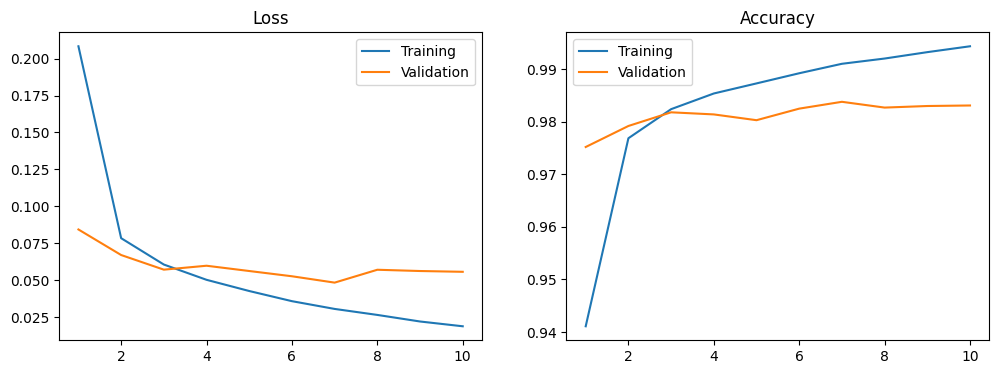

In [13]:
def plot_loss_acc(history, epoch):

  loss, val_loss = history.history['loss'], history.history['val_loss']
  acc, val_acc = history.history['accuracy'], history.history['val_accuracy']

  fig, axes = plt.subplots(1,2,figsize=(12,4))

  axes[0].plot(range(1, epoch+1), loss, label='Training')
  axes[0].plot(range(1, epoch+1), val_loss, label='Validation')
  axes[0].legend(loc='best')
  axes[0].set_title('Loss')

  axes[1].plot(range(1, epoch+1), acc, label='Training')
  axes[1].plot(range(1, epoch+1), val_acc, label='Validation')
  axes[1].legend(loc='best')
  axes[1].set_title('Accuracy')

  plt.show()

plot_loss_acc(history, 10)

### 2-3 모델 구조 파악
- summary()

In [14]:
# 모델 구조
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv (Conv2D)               (None, 26, 26, 32)        320       
                                                                 
 pool (MaxPooling2D)         (None, 13, 13, 32)        0         
                                                                 
 flatten (Flatten)           (None, 5408)              0         
                                                                 
 dense (Dense)               (None, 10)                54090     
                                                                 
Total params: 54410 (212.54 KB)
Trainable params: 54410 (212.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


- 가장 앞에 있는 축의 None 값은 배치 크기가 들어오는 위치, 배치 크기로 어떤 값이든 가능

In [15]:
# 입력 텐서 형태
model.input

<KerasTensor: shape=(None, 28, 28, 1) dtype=float32 (created by layer 'conv_input')>

In [16]:
# 출력 텐서 형태
model.output

<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'dense')>

In [17]:
model.layers

In [18]:
# 첫번째 레이어 선택
model.layers[0]

In [19]:
# 첫번째 레이어 입력
model.layers[0].input

<KerasTensor: shape=(None, 28, 28, 1) dtype=float32 (created by layer 'conv_input')>

In [20]:
# 첫번째 레이어 출력
model.layers[0].output

<KerasTensor: shape=(None, 26, 26, 32) dtype=float32 (created by layer 'conv')>

- 레이어의 가중치 행렬 추출
  - 첫번째 변수 : 커널 행렬의 가중치
  - 두번째 변수 : 커널의 상수항

In [21]:
# 첫번째 레이어 가중치
model.layers[0].weights

[<tf.Variable 'conv/kernel:0' shape=(3, 3, 1, 32) dtype=float32, numpy=
 array([[[[-6.55123591e-01, -1.23135507e+00,  3.81819218e-01,
            3.31559986e-01, -7.07785904e-01,  4.58318830e-01,
            1.66538820e-01,  3.53770345e-01,  2.35378936e-01,
            1.00185029e-01,  1.68049056e-02,  2.90445477e-01,
           -5.82353115e-01, -4.28000271e-01,  1.51939899e-01,
           -7.92575598e-01, -1.42743850e+00,  3.29618692e-01,
           -6.21910989e-01, -5.66913962e-01, -1.10249177e-01,
           -7.91017830e-01,  1.93285018e-01,  3.15401793e-01,
            1.01722546e-01,  1.69653073e-01, -5.83611310e-01,
           -4.32695299e-01,  2.28778377e-01,  1.52729198e-01,
           -3.40866894e-01,  2.31038883e-01]],
 
         [[-9.90234166e-02, -9.24841344e-01,  1.52467564e-01,
            4.01244253e-01,  9.31316689e-02, -5.77020869e-02,
            5.53136587e-01,  2.48608157e-01,  3.81786019e-01,
           -8.28173012e-02, -5.88029563e-01,  3.98499995e-01,
           

In [22]:
# 첫번째 레이어 커널 가중치
model.layers[0].kernel

<tf.Variable 'conv/kernel:0' shape=(3, 3, 1, 32) dtype=float32, numpy=
array([[[[-6.55123591e-01, -1.23135507e+00,  3.81819218e-01,
           3.31559986e-01, -7.07785904e-01,  4.58318830e-01,
           1.66538820e-01,  3.53770345e-01,  2.35378936e-01,
           1.00185029e-01,  1.68049056e-02,  2.90445477e-01,
          -5.82353115e-01, -4.28000271e-01,  1.51939899e-01,
          -7.92575598e-01, -1.42743850e+00,  3.29618692e-01,
          -6.21910989e-01, -5.66913962e-01, -1.10249177e-01,
          -7.91017830e-01,  1.93285018e-01,  3.15401793e-01,
           1.01722546e-01,  1.69653073e-01, -5.83611310e-01,
          -4.32695299e-01,  2.28778377e-01,  1.52729198e-01,
          -3.40866894e-01,  2.31038883e-01]],

        [[-9.90234166e-02, -9.24841344e-01,  1.52467564e-01,
           4.01244253e-01,  9.31316689e-02, -5.77020869e-02,
           5.53136587e-01,  2.48608157e-01,  3.81786019e-01,
          -8.28173012e-02, -5.88029563e-01,  3.98499995e-01,
           1.68450654e-01,  

In [23]:
# 첫번째 레이어 bias 가중치
model.layers[0].bias

<tf.Variable 'conv/bias:0' shape=(32,) dtype=float32, numpy=
array([-0.00540405,  0.00827444, -0.25615108, -0.11121126, -0.09561388,
       -0.22279401, -0.08666487, -0.35429657, -0.13420099, -0.14069907,
       -0.0135707 , -0.35862723, -0.10060494, -0.00692873, -0.01239291,
       -0.06356183,  0.19968957, -0.36307964, -0.02929725, -0.06097103,
       -0.25130937, -0.00356713, -0.26521182, -0.3282844 , -0.02006447,
       -0.19075306, -0.146722  , -0.01547142, -0.30369726, -0.31598675,
       -0.08344885, -0.25978088], dtype=float32)>

In [24]:
# 레이어 이름 이용하여 레이어 선택
model.get_layer('conv')

In [26]:
# 샘플 이미지의 레이어별 출력을 리스트에 추가(첫번째, 두번째 레이어)
activator=tf.keras.Model(inputs=model.input,
                         outputs=[layer.output for layer in model.layers[:2]])
activations=activator.predict(x_train_in[0][tf.newaxis,...])
len(activations)

1/1 [==============================] - 0s 208ms/step


2

In [27]:
# 첫번째 레이어 출력층
conv_activation=activations[0]
conv_activation.shape

(1, 26, 26, 32)

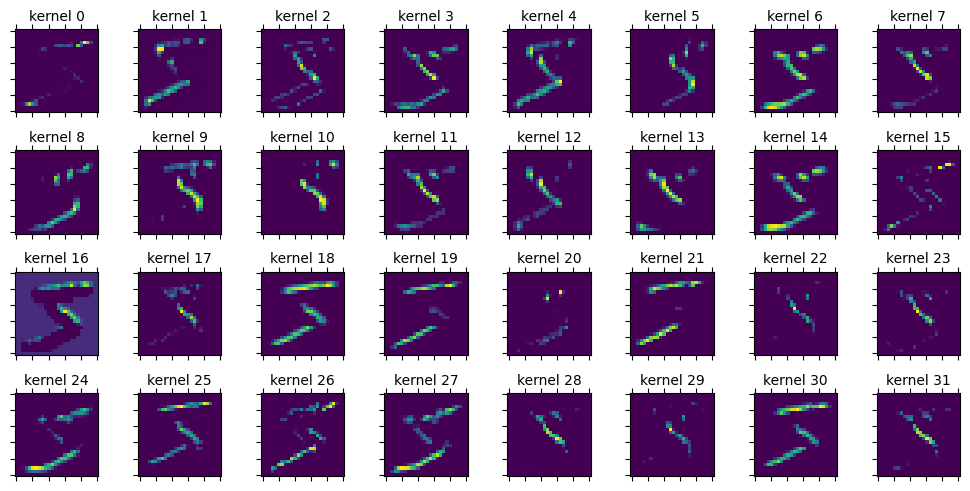

In [28]:
# Convolution 시각화
fig, axes = plt.subplots(4,8)
fig.set_size_inches(10,5)

for i in range(32):
  axes[i//8, i%8].matshow(conv_activation[0,:,:,i], cmap='viridis')
  axes[i//8, i%8].set_title('kernel %s'%str(i), fontsize=10)
  plt.setp(axes[i//8, i%8].get_xticklabels(), visible=False)
  plt.setp(axes[i//8, i%8].get_yticklabels(), visible=False)

plt.tight_layout()
plt.show()

- 각 커널은 입력 이미지로부터 서로 다른 피처를 추출하는 역할

In [29]:
# 두번째 레이어(pool) 출력층
pooling_activation = activations[1]
pooling_activation.shape

(1, 13, 13, 32)

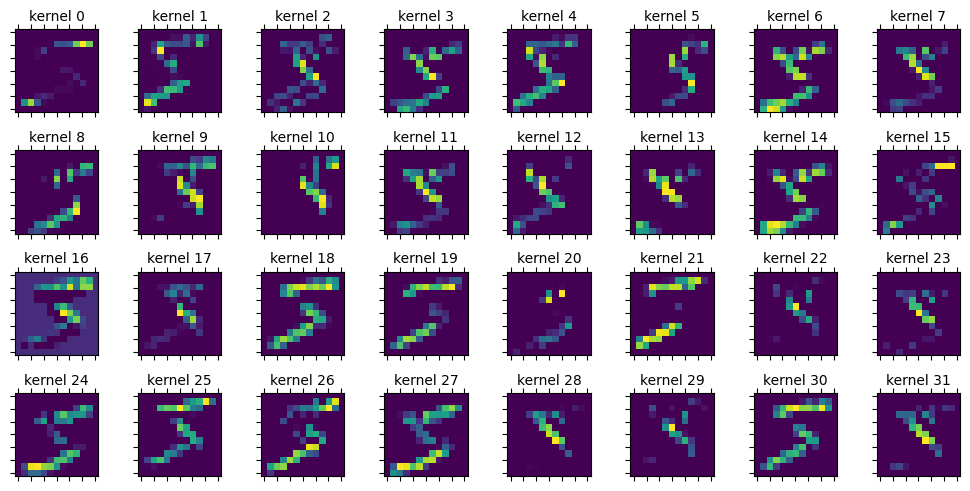

In [30]:
# 시각화
fig, axes = plt.subplots(4,8)
fig.set_size_inches(10,5)

for i in range(32):
  axes[i//8, i%8].matshow(pooling_activation[0,:,:,i], cmap='viridis')
  axes[i//8, i%8].set_title('kernel %s'%str(i), fontsize=10)
  plt.setp(axes[i//8, i%8].get_xticklabels(), visible=False)
  plt.setp(axes[i//8, i%8].get_yticklabels(), visible=False)

plt.tight_layout()
plt.show()


- 최대 풀링은 인근 픽셀을 모아서 최대값으로 고정하기 때문에 픽셀 수는 줄이면서 특징 강하게 드러낼 수 있다

## 03 복잡한 모델 생성
### 3-1 데이터셋 준비
- 0~9 까지 숫자를 맞추는 정답 + 홀수인지 짝수인지 판단하는 정답
- y_train이 홀수이면 1, 짝수이면 0으로 하는 y_train_odd 배열 추가

In [31]:
# tensorflow 모듈 import
import tensorflow as tf
import numpy as np

# mnist 손글씨 이미지 데이터 로드
mnist = tf.keras.datasets.mnist
(x_train, y_train),(x_valid, y_valid) = mnist.load_data()

print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


In [32]:
# 새로운 출력 값 배열 생성(홀수:1, 짝수:0)
y_train_odd = []
for y in y_train:
  if y % 2 == 0:
    y_train_odd.append(0)
  else:
    y_train_odd.append(1)

y_train_odd = np.array(y_train_odd)
y_train_odd.shape

(60000,)

In [34]:
print(y_train[:10])
print(y_train_odd[:10])

[5 0 4 1 9 2 1 3 1 4]
[1 0 0 1 1 0 1 1 1 0]


In [35]:
# Validation 데이터셋 처리
y_valid_odd = []
for y in y_valid:
  if y % 2 == 0:
    y_valid_odd.append(0)
  else:
    y_valid_odd.append(1)

y_valid_odd = np.array(y_valid_odd)
y_valid_odd.shape

(10000,)

- 축의 인덱스를 -1로 지정하여 새로운 축은 끝에 추가

In [36]:
# 정규화
x_train = x_train / 255.0
x_valid = x_valid / 255.0

# 채널 추가
x_train_in = tf.expand_dims(x_train, -1)
x_valid_in = tf.expand_dims(x_valid, -1)

print(x_train_in.shape, x_valid_in.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1)


### 3-2 functional api 로 다중입력, 다중 출력 레이어 생성

In [37]:
# Functional API를 사용하여 모델 생성

inputs = tf.keras.layers.Input(shape=(28,28,1))

conv = tf.keras.layers.Conv2D(32,(3,3), activation='relu')(inputs)
pool = tf.keras.layers.MaxPooling2D((2,2))(conv)
flat = tf.keras.layers.Flatten()(pool)

flat_inputs = tf.keras.layers.Flatten()(inputs)
concat = tf.keras.layers.Concatenate()([flat, flat_inputs])
outputs = tf.keras.layers.Dense(10, activation='softmax')(concat)

model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 26, 26, 32)           320       ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)           0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 flatten_1 (Flatten)         (None, 5408)                 0         ['max_pooling2d[0][0]'] 

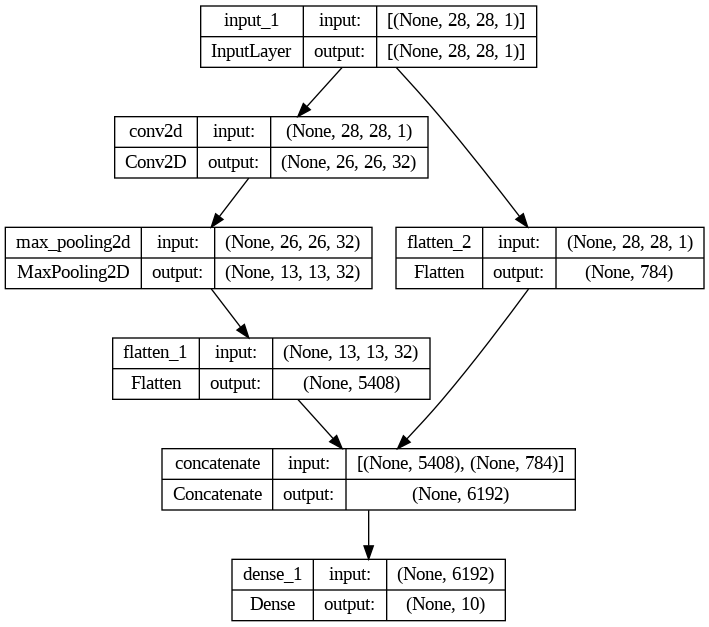

In [38]:
# 모델 구조 출력 및 이미지 파일로 저장
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

In [39]:
# 모델 컴파일
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 모델 훈련
history = model.fit(x_train_in, y_train,
                    validation_data=(x_valid_in, y_valid),
                    epochs=10)

# 모델 성능
val_loss, val_acc = model.evaluate(x_valid_in, y_valid)
print(val_loss, val_acc)

Epoch 1/10
1875/1875 [==============================] - 27s 14ms/step - loss: 0.2034 - accuracy: 0.9412 - val_loss: 0.0919 - val_accuracy: 0.9723
Epoch 2/10
1875/1875 [==============================] - 27s 14ms/step - loss: 0.0795 - accuracy: 0.9765 - val_loss: 0.0691 - val_accuracy: 0.9775
Epoch 3/10
1875/1875 [==============================] - 25s 13ms/step - loss: 0.0596 - accuracy: 0.9819 - val_loss: 0.0648 - val_accuracy: 0.9793
Epoch 4/10
1875/1875 [==============================] - 26s 14ms/step - loss: 0.0490 - accuracy: 0.9850 - val_loss: 0.0562 - val_accuracy: 0.9810
Epoch 5/10
1875/1875 [==============================] - 25s 13ms/step - loss: 0.0416 - accuracy: 0.9874 - val_loss: 0.0630 - val_accuracy: 0.9804
Epoch 6/10
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0341 - accuracy: 0.9899 - val_loss: 0.0618 - val_accuracy: 0.9822
Epoch 7/10
1875/1875 [==============================] - 24s 13ms/step - loss: 0.0291 - accuracy: 0.9908 - val_loss: 0.0607 -

### 3-3 다중 출력 분류 모델
- 최종 분류기의 출력 레이어를 2개 만드는 것이 핵심

In [40]:
# Functional API를 사용하여 모델 생성

inputs = tf.keras.layers.Input(shape=(28,28,1), name='inputs')

conv = tf.keras.layers.Conv2D(32,(3,3), activation='relu', name='conv2d_layer')(inputs)
pool = tf.keras.layers.MaxPooling2D((2,2), name='maxpool_layer')(conv)
flat = tf.keras.layers.Flatten(name='flatten_layer')(pool)

flat_inputs = tf.keras.layers.Flatten()(inputs)
concat = tf.keras.layers.Concatenate()([flat, flat_inputs])
digit_outputs = tf.keras.layers.Dense(10, activation='softmax', name='digit_dense')(concat)

odd_outputs = tf.keras.layers.Dense(1, activation='sigmoid', name='odd_dense')(flat_inputs)

model = tf.keras.models.Model(inputs=inputs, outputs=[digit_outputs,odd_outputs])

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 inputs (InputLayer)         [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d_layer (Conv2D)       (None, 26, 26, 32)           320       ['inputs[0][0]']              
                                                                                                  
 maxpool_layer (MaxPooling2  (None, 13, 13, 32)           0         ['conv2d_layer[0][0]']        
 D)                                                                                               
                                                                                                  
 flatten_layer (Flatten)     (None, 5408)                 0         ['maxpool_layer[0][0]'] 

In [41]:
# 모델의 입력과 출력을 나타내는 텐서
print(model.input)
print(model.output)

KerasTensor(type_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='inputs'), name='inputs', description="created by layer 'inputs'")
[<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'digit_dense')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'odd_dense')>]


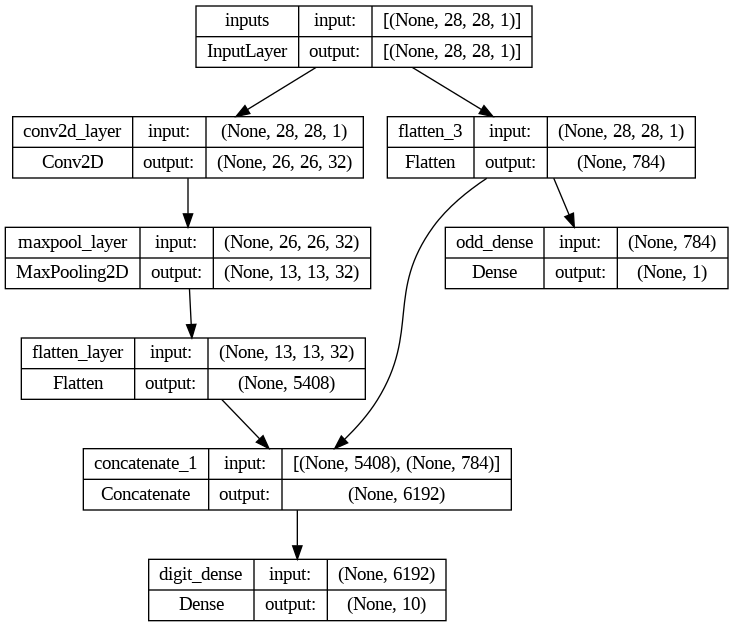

In [42]:
plot_model(model, show_shapes=True, show_layer_names=True)

- 해당 key에 해당하는 레이어에 적용할 손실함수와 가중치를 딕셔너리 형태로 지정

In [43]:
# 모델 컴파일
model.compile(optimizer='adam', loss={'digit_dense':'sparse_categorical_crossentropy','odd_dense':'binary_crossentropy'},
              loss_weights={'digit_dense':1,'odd_dense':0.5}, metrics=['accuracy'])

# 모델 훈련
history = model.fit({'inputs':x_train_in},{'digit_dense':y_train,'odd_dense':y_train_odd},
                    validation_data=({'inputs':x_valid_in}, {'digit_dense':y_valid,'odd_dense':y_valid_odd}),
                    epochs=10)

Epoch 1/10
1875/1875 [==============================] - 26s 13ms/step - loss: 0.3760 - digit_dense_loss: 0.2146 - odd_dense_loss: 0.3229 - digit_dense_accuracy: 0.9383 - odd_dense_accuracy: 0.8652 - val_loss: 0.2262 - val_digit_dense_loss: 0.0886 - val_odd_dense_loss: 0.2751 - val_digit_dense_accuracy: 0.9719 - val_odd_dense_accuracy: 0.8890
Epoch 2/10
1875/1875 [==============================] - 29s 16ms/step - loss: 0.2167 - digit_dense_loss: 0.0808 - odd_dense_loss: 0.2718 - digit_dense_accuracy: 0.9764 - odd_dense_accuracy: 0.8910 - val_loss: 0.1999 - val_digit_dense_loss: 0.0683 - val_odd_dense_loss: 0.2632 - val_digit_dense_accuracy: 0.9782 - val_odd_dense_accuracy: 0.8953
Epoch 3/10
1875/1875 [==============================] - 28s 15ms/step - loss: 0.1913 - digit_dense_loss: 0.0600 - odd_dense_loss: 0.2627 - digit_dense_accuracy: 0.9817 - odd_dense_accuracy: 0.8957 - val_loss: 0.1995 - val_digit_dense_loss: 0.0705 - val_odd_dense_loss: 0.2580 - val_digit_dense_accuracy: 0.9777 -

In [44]:
# 모델 성능
model.evaluate({'inputs':x_valid_in},{'digit_dense':y_valid,'odd_dense':y_valid_odd})

313/313 [==============================] - 2s 5ms/step - loss: 0.1879 - digit_dense_loss: 0.0593 - odd_dense_loss: 0.2573 - digit_dense_accuracy: 0.9837 - odd_dense_accuracy: 0.9026


[0.18792951107025146,
 0.059272151440382004,
 0.2573145925998688,
 0.9836999773979187,
 0.9025999903678894]

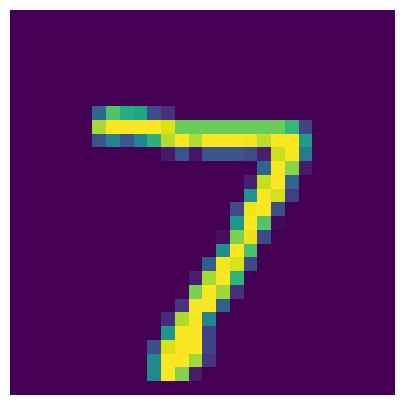

In [45]:
# 샘플 이미지 출력
def plot_image(data,idx):
  plt.figure(figsize=(5,5))
  plt.imshow(data[idx])
  plt.axis('off')
  plt.show()

plot_image(x_valid,0)

- 검증 데이터셋의 모든 이미지 데이터를 입력하여 2개의 분류문제에 대한 예측 확률 구하기

In [46]:
digit_preds, odd_preds = model.predict(x_valid_in)

# 숫자 7 이미지 예측확률
print(digit_preds[0])
print(odd_preds[0])

313/313 [==============================] - 1s 4ms/step
[5.40294094e-14 1.30294785e-11 2.79230500e-10 1.75072529e-07
 1.09882502e-12 1.35319449e-13 1.04772037e-20 9.99999821e-01
 7.37062023e-10 1.44984087e-08]
[0.9994824]


- argmax 함수를 이용하여 예측 확률을 실제 정답 레이블로 변환

In [48]:
digit_labels=np.argmax(digit_preds,axis=1)
digit_labels[0:10]

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9])

- 임계값 0.5로 지정

In [49]:
odd_labels = (odd_preds > 0.5).astype(np.int64).reshape(1,-1)[0]

### 3-4 전이 학습
- 앞서 훈련한 모델의 일부를 가져와서 그대로 사용, 최종 출력층만 새롭게 추가하여 모델 재구성

In [50]:
# 앞의 모델에서 flatten_layer 출력을 추출
base_model_output = model.get_layer('flatten_layer').output

# 앞의 출력을 출력으로 하는 모델 정의
base_model = tf.keras.models.Model(inputs=model.input, outputs=base_model_output, name='base')
base_model.summary()

Model: "base"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_layer (Conv2D)       (None, 26, 26, 32)        320       
                                                                 
 maxpool_layer (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 flatten_layer (Flatten)     (None, 5408)              0         
                                                                 
Total params: 320 (1.25 KB)
Trainable params: 320 (1.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


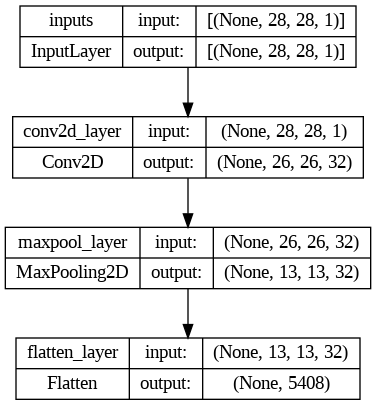

In [51]:
plot_model(base_model, show_shapes=True, show_layer_names=True)

- 최종 분류기 역할을 하는 Dense 레이어를 추가

In [52]:
# Sequential API 적용
digit_model = tf.keras.Sequential([base_model,
                                   tf.keras.layers.Dense(10, activation='softmax')])
digit_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 base (Functional)           (None, 5408)              320       
                                                                 
 dense_2 (Dense)             (None, 10)                54090     
                                                                 
Total params: 54410 (212.54 KB)
Trainable params: 54410 (212.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


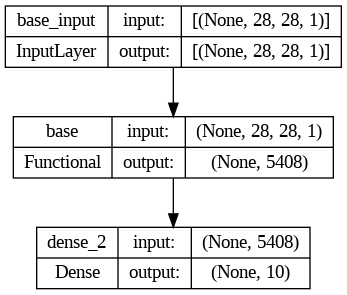

In [53]:
plot_model(digit_model, show_shapes=True, show_layer_names=True)

In [54]:
# 모델 컴파일
digit_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 모델 훈련
history = digit_model.fit(x_train_in, y_train, validation_data=(x_valid_in, y_valid), epochs=10)

Epoch 1/10
1875/1875 [==============================] - 25s 13ms/step - loss: 0.1311 - accuracy: 0.9635 - val_loss: 0.0623 - val_accuracy: 0.9810
Epoch 2/10
1875/1875 [==============================] - 28s 15ms/step - loss: 0.0579 - accuracy: 0.9830 - val_loss: 0.0568 - val_accuracy: 0.9807
Epoch 3/10
1875/1875 [==============================] - 24s 13ms/step - loss: 0.0447 - accuracy: 0.9864 - val_loss: 0.0500 - val_accuracy: 0.9842
Epoch 4/10
1875/1875 [==============================] - 28s 15ms/step - loss: 0.0356 - accuracy: 0.9890 - val_loss: 0.0515 - val_accuracy: 0.9839
Epoch 5/10
1875/1875 [==============================] - 24s 13ms/step - loss: 0.0294 - accuracy: 0.9904 - val_loss: 0.0533 - val_accuracy: 0.9843
Epoch 6/10
1875/1875 [==============================] - 27s 14ms/step - loss: 0.0235 - accuracy: 0.9931 - val_loss: 0.0567 - val_accuracy: 0.9848
Epoch 7/10
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0198 - accuracy: 0.9940 - val_loss: 0.0599 -

- 파라미터 값 고정하여 훈련 통해 업데이트 되지 않도록 하는 방법

In [55]:
# 베이스 모델의 가중치 고정 (Freeze Model)

base_model_frozen = tf.keras.models.Model(inputs=model.input, outputs=base_model_output, name='base_frozen')
base_model_frozen.trainable = False
base_model_frozen.summary()

Model: "base_frozen"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_layer (Conv2D)       (None, 26, 26, 32)        320       
                                                                 
 maxpool_layer (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 flatten_layer (Flatten)     (None, 5408)              0         
                                                                 
Total params: 320 (1.25 KB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 320 (1.25 KB)
_________________________________________________________________


In [56]:
# Functional API 적용
dense_output = tf.keras.layers.Dense(10, activation='softmax')(base_model_frozen.output)
digit_model_frozen = tf.keras.models.Model(inputs=base_model_frozen.input, outputs=dense_output)
digit_model_frozen.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_layer (Conv2D)       (None, 26, 26, 32)        320       
                                                                 
 maxpool_layer (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 flatten_layer (Flatten)     (None, 5408)              0         
                                                                 
 dense_3 (Dense)             (None, 10)                54090     
                                                                 
Total params: 54410 (212.54 KB)
Trainable params: 54090 (211.29 KB)
Non-trainable params: 320 (1.25 KB)
_____________________

In [57]:
# 모델 컴파일
digit_model_frozen.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 모델 훈련
history = digit_model_frozen.fit(x_train_in, y_train, validation_data=(x_valid_in, y_valid), epochs=10)

Epoch 1/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.1152 - accuracy: 0.9693 - val_loss: 0.0526 - val_accuracy: 0.9835
Epoch 2/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0489 - accuracy: 0.9851 - val_loss: 0.0514 - val_accuracy: 0.9836
Epoch 3/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0364 - accuracy: 0.9890 - val_loss: 0.0546 - val_accuracy: 0.9823
Epoch 4/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0278 - accuracy: 0.9915 - val_loss: 0.0501 - val_accuracy: 0.9848
Epoch 5/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0226 - accuracy: 0.9935 - val_loss: 0.0554 - val_accuracy: 0.9834
Epoch 6/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0180 - accuracy: 0.9947 - val_loss: 0.0540 - val_accuracy: 0.9837
Epoch 7/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0146 - accuracy: 0.9956 - val_loss: 0.0552 - val_ac

- 모델 전체가 아니라 특정 레이어를 지정하여 파라미터 고정하는 방법

In [58]:
# 베이스 모델의 Conv2D 레이어의 가중치만 고정 (Freeze Layer)
base_model_frozen2 = tf.keras.models.Model(inputs=model.input, outputs=base_model_output, name='base_frozen2')
base_model_frozen2.get_layer('conv2d_layer').trainable = False
base_model_frozen2.summary()

Model: "base_frozen2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_layer (Conv2D)       (None, 26, 26, 32)        320       
                                                                 
 maxpool_layer (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 flatten_layer (Flatten)     (None, 5408)              0         
                                                                 
Total params: 320 (1.25 KB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 320 (1.25 KB)
_________________________________________________________________


In [59]:
# Functional API 적용
dense_output2 = tf.keras.layers.Dense(10, activation='softmax')(base_model_frozen2.output)
digit_model_frozen2 = tf.keras.models.Model(inputs=base_model_frozen2.input, outputs=dense_output2)
digit_model_frozen2.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_layer (Conv2D)       (None, 26, 26, 32)        320       
                                                                 
 maxpool_layer (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 flatten_layer (Flatten)     (None, 5408)              0         
                                                                 
 dense_4 (Dense)             (None, 10)                54090     
                                                                 
Total params: 54410 (212.54 KB)
Trainable params: 54090 (211.29 KB)
Non-trainable params: 320 (1.25 KB)
_____________________

In [60]:
# 모델 컴파일
digit_model_frozen2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 모델 훈련
history = digit_model_frozen2.fit(x_train_in, y_train,
                          validation_data=(x_valid_in, y_valid),
                          epochs=10)

Epoch 1/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.1162 - accuracy: 0.9683 - val_loss: 0.0611 - val_accuracy: 0.9804
Epoch 2/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0494 - accuracy: 0.9854 - val_loss: 0.0581 - val_accuracy: 0.9817
Epoch 3/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0359 - accuracy: 0.9891 - val_loss: 0.0530 - val_accuracy: 0.9828
Epoch 4/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0280 - accuracy: 0.9913 - val_loss: 0.0534 - val_accuracy: 0.9830
Epoch 5/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0228 - accuracy: 0.9933 - val_loss: 0.0549 - val_accuracy: 0.9828
Epoch 6/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0180 - accuracy: 0.9948 - val_loss: 0.0532 - val_accuracy: 0.9836
Epoch 7/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0150 - accuracy: 0.9955 - val_loss: 0.0617 - val_ac